In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import cv2  
from tqdm import tqdm
from random import randint
import json
import matplotlib.image as mpimg
from matplotlib import rcParams

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.applications.vgg16 import VGG16 
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA



In [2]:
train_path = "data/train"
test_path = "data/test"

train = os.listdir(train_path)
test = os.listdir(test_path)

In [3]:
train_image = [cv2.cvtColor(cv2.imread(os.path.join(train_path, image)), cv2.COLOR_BGR2RGB)  for image in train ]

In [4]:
test_image = [cv2.cvtColor(cv2.imread(os.path.join(test_path, image)), cv2.COLOR_BGR2RGB)  for image in test ]

In [5]:
trian_label = pd.read_csv("data/imagenames.csv")


# load the model
model = ResNet50(weights='imagenet')


# Object

In [9]:
test_object = {}

for i in tqdm(range(len(test))):
    imgpath = test_path+"/"+test[i]
    img = image.load_img(imgpath, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    k_img = preprocess_input(img)
    preds = model.predict(k_img)

    test_object[test[i]] = {}
    detect_object = [pred[1] for pred in decode_predictions(preds, top=5)[0]]
    detect_weight = [pred[2] for pred in decode_predictions(preds, top=5)[0]]

    test_object[test[i]]["detect_object"] = detect_object
    test_object[test[i]]["detect_weight"] = detect_weight



100%|██████████| 1200/1200 [01:02<00:00, 19.35it/s]


In [11]:
train_object = {}

for i in tqdm(range(len(train))):
    imgpath = train_path+"/"+train[i]
    img = image.load_img(imgpath, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    k_img = preprocess_input(img)
    preds = model.predict(k_img)

    train_object[train[i]] = {}
    detect_object = [pred[1] for pred in decode_predictions(preds, top=5)[0]]
    detect_weight = [pred[2] for pred in decode_predictions(preds, top=5)[0]]

    train_object[train[i]]["detect_object"] = detect_object
    train_object[train[i]]["detect_weight"] = detect_weight

100%|██████████| 7500/7500 [05:42<00:00, 21.88it/s]


# Vgg 16 features

In [6]:
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [7]:
data = {}

for i in tqdm(range(len(train))):
    imgpath = train_path+"/"+train[i]
    img = image.load_img(imgpath, target_size=(224, 224))
    img = np.array(img)
    reshaped_img = img.reshape(1,224,224,3) 

    
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)

    data[train[i]] = features

100%|██████████| 7500/7500 [05:24<00:00, 23.11it/s]


In [123]:
data

{'IMG2744_1.jpg': array([[2.309288  , 1.7636896 , 0.22244555, ..., 0.7218894 , 1.429806  ,
         0.        ]], dtype=float32),
 'IMG2744_2.jpg': array([[1.3842635 , 0.919799  , 0.        , ..., 0.6547646 , 2.5407434 ,
         0.46790916]], dtype=float32),
 'IMG2744_3.jpg': array([[0.       , 1.5789081, 1.1104891, ..., 4.1375003, 2.1253304,
         0.5644894]], dtype=float32),
 'IMG2744_4.jpg': array([[2.2282329, 2.9938695, 2.4327402, ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 'IMG2744_5.jpg': array([[0.28176984, 0.        , 2.2380176 , ..., 0.        , 1.4996321 ,
         0.        ]], dtype=float32),
 'IMG2745_1.jpg': array([[0.03817183, 2.3302965 , 0.7669468 , ..., 0.        , 0.7291356 ,
         0.46456376]], dtype=float32),
 'IMG2745_2.jpg': array([[1.5207993, 2.2528398, 1.4123926, ..., 0.       , 1.5309474,
         0.       ]], dtype=float32),
 'IMG2745_3.jpg': array([[4.208268 , 3.8684452, 3.6861053, ..., 0.       , 0.       ,
         0.       ]], 

In [129]:
with open('data/train_vgg_features.json', 'w') as train_vgg_features:
    json.dump({k: v.tolist() for k, v in data.items()}, train_vgg_features)

In [8]:
test_data = {}

for i in tqdm(range(len(test))):
    imgpath = test_path+"/"+test[i]
    img = image.load_img(imgpath, target_size=(224, 224))
    img = np.array(img)
    reshaped_img = img.reshape(1,224,224,3) 

    
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)

    test_data[test[i]] = features

100%|██████████| 1200/1200 [00:51<00:00, 23.46it/s]


In [132]:
with open('data/test_vgg_features.json', 'w') as test_vgg_features:
    json.dump({k: v.tolist() for k, v in test_data.items()}, test_vgg_features)

# PCA = 100

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [10]:
filenames = np.array(list(data.keys()))

# get a list of just the features
feat_train = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat_train = feat_train.reshape(-1,4096)

In [11]:
filenames_test = np.array(list(test_data.keys()))

# get a list of just the features
feat_test = np.array(list(test_data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat_test = feat_test.reshape(-1,4096)

In [15]:
scaler = StandardScaler()
scaler.fit(feat_train)
feat_train = scaler.transform(feat_train)
feat_test = scaler.transform(feat_test)

In [370]:
pca_100 = PCA(n_components=100, random_state=22)
pca_100.fit(feat_train)
x_train = pca_100.transform(feat_train)
x_test = pca_100.transform(feat_test)

print(sum(pca_100.explained_variance_ratio_))

0.6192511818371713


# Cluster k = 2

In [371]:
kmeans_2 = KMeans(n_clusters=2,n_jobs=-1, random_state=22)
kmeans_2 = kmeans_2.fit(x_train)
pca_100_train_2_s = kmeans_2.predict(x_train)
pca_100_test_2_s = kmeans_2.predict(x_test)

E:\ANACONDA\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


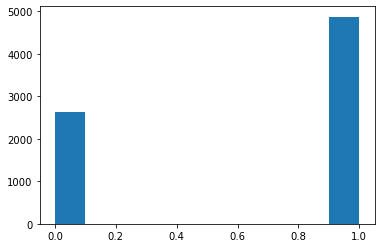

In [372]:
plt.hist(pca_100_train_2_s)
plt.show()

# Cluster K = 20

In [373]:
kmeans_20 = KMeans(n_clusters=20,n_jobs=-1, random_state=22)
kmeans_20 = kmeans_20.fit(x_train)
pca_100_train_20_s = kmeans_20.predict(x_train)
pca_100_test_20_s = kmeans_20.predict(x_test)

E:\ANACONDA\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


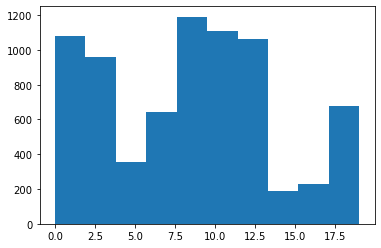

In [374]:
plt.hist(pca_100_train_20_s)
plt.show()

In [17]:
train_feature = pd.read_csv("data/train_features.csv")
test_feature = pd.read_csv("data/test_features.csv")

In [ ]:
train_feature["PCA_100_cluster_2_without_concat"] = pca_100_train_2_s
test_feature["PCA_100_cluster_2_without_concat"] = pca_100_test_2_s

In [377]:
train_feature["PCA_100_cluster_20_without_concat"] = pca_100_train_20_s
test_feature["PCA_100_cluster_20_without_concat"] = pca_100_test_20_s

# PCA = 500

In [12]:
pca_500 = PCA(n_components=500, random_state=22)
pca_500.fit(feat_train)
x_train = pca_500.transform(feat_train)
x_test = pca_500.transform(feat_test)

print(sum(pca_500.explained_variance_ratio_))

0.9023376966506476


# Cluster K = 2

In [379]:
kmeans_2 = KMeans(n_clusters=2,n_jobs=-1, random_state=22)
kmeans_2 = kmeans_2.fit(x_train)
pca_500_train_2_s = kmeans_2.predict(x_train)
pca_500_test_2_s = kmeans_2.predict(x_test)

E:\ANACONDA\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


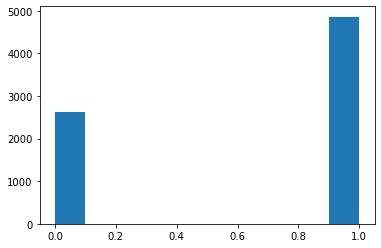

In [380]:
plt.hist(pca_500_train_2_s)
plt.show()

# Cluster K = 20

In [19]:
kmeans_20 = KMeans(n_clusters=20,n_jobs=-1, random_state=22)
kmeans_20 = kmeans_20.fit(x_train)
pca_500_train_20_s = kmeans_20.predict(x_train)
pca_500_test_20_s = kmeans_20.predict(x_test)

E:\ANACONDA\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


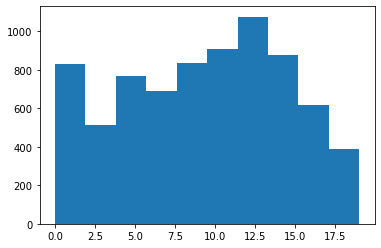

In [237]:
plt.hist(pca_500_train_20_s)
plt.show()

# K = 10

In [13]:
kmeans_10 = KMeans(n_clusters=10,n_jobs=-1, random_state=22)
kmeans_10 = kmeans_10.fit(x_train)
pca_500_train_10_s = kmeans_10.predict(x_train)
pca_500_test_10_s = kmeans_10.predict(x_test)

E:\ANACONDA\envs\GAN\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


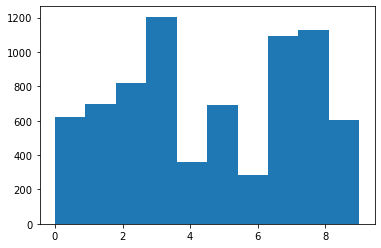

In [21]:
plt.hist(pca_500_train_10_s)
plt.show()

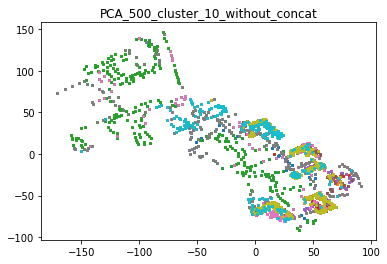

<Figure size 864x864 with 0 Axes>

In [20]:
groups = train_feature.groupby('PCA_500_cluster_10_without_concat')

# Plot
fig, ax = plt.subplots()
plt.figure(figsize=(12,12))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=2, label=name)
    ax.set_title("PCA_500_cluster_10_without_concat")
plt.savefig("image/PCA_500_cluster_10_without_concat.png")

In [42]:
train_feature["PCA_500_cluster_10_without_concat"] = pca_500_train_10_s
test_feature["PCA_500_cluster_10_without_concat"] = pca_500_test_10_s

In [382]:
train_feature["PCA_500_cluster_2_without_concat"] = pca_500_train_2_s
test_feature["PCA_500_cluster_2_without_concat"] = pca_500_test_2_s
train_feature["PCA_500_cluster_20_without_concat"] = pca_500_train_20_s
test_feature["PCA_500_cluster_20_without_concat"] = pca_500_test_20_s

In [43]:
train_feature.to_csv("data/train_features.csv",index = False)
test_feature.to_csv("data/test_features.csv",index = False)

# Image concat

In [12]:
train_feature["cluster"]

0       IMG2744
1       IMG2744
2       IMG2744
3       IMG2744
4       IMG2744
         ...   
7495    IMG4243
7496    IMG4243
7497    IMG4243
7498    IMG4243
7499    IMG4243
Name: cluster, Length: 7500, dtype: object

In [27]:
# concat_image = []
# temp_cluster = train_feature["cluster"][0]
# concate = []
# cluster_name = [train_feature["cluster"][0]]
# for i in tqdm(range(len(train))):      
#     if temp_cluster == train_feature["cluster"][i]:
#         concate.append(train_image[i])
#     else:
#         cluster_name.append(temp_cluster)
#         temp_cluster = train_feature["cluster"][i]
#         concat_image.append(cv2.hconcat(concate))
#         concate = []
# concat_image.append(cv2.hconcat(concate))
       

100%|██████████| 7500/7500 [00:27<00:00, 272.74it/s]


In [13]:
d = {}
temp_cluster = train_feature["cluster"][0]
concate = []
concat_image = []
cluster_name = [train_feature["cluster"][0]]

for i in tqdm(range(len(train))):      
    if temp_cluster == train_feature["cluster"][i]:
        concate.append(train_image[i])
    else:
        d[temp_cluster] = cv2.hconcat(concate)
        temp_cluster = train_feature["cluster"][i]
        concate = []
d[temp_cluster] = cv2.hconcat(concate)

100%|██████████| 7500/7500 [00:24<00:00, 309.65it/s]


In [29]:
list(d.keys())[0]

'IMG2744'

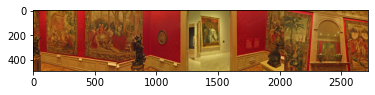

In [30]:
plt.imshow(d[list(d.keys())[2]], cmap='gray')

In [339]:
len(d.values())

1500

In [14]:
concate_data = {}

for key in tqdm(d.keys()):
    image = d[key]
    img = np.array(image)
    img = cv2.resize(img, (224,224))
    reshaped_img = img.reshape(1,224,224,3) 

    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)

    concate_data[key] = features

100%|██████████| 1500/1500 [01:03<00:00, 23.66it/s]


In [355]:
with open('data/concate_train_vgg_features.json', 'w') as concate_train_vgg_features:
    json.dump({k: v.tolist() for k, v in concate_data.items()}, concate_train_vgg_features)

In [15]:
filenames_concate = np.array(list(concate_data.keys()))

# get a list of just the features
feat_concate = np.array(list(concate_data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat_concate = feat_concate.reshape(-1,4096)

In [16]:
scaler = StandardScaler()
scaler.fit(feat_concate)
feat_concate = scaler.transform(feat_concate)
feat_test = scaler.transform(feat_test)

# PCA = 100


In [17]:
pca_100 = PCA(n_components=100, random_state=22)
pca_100.fit(feat_concate)
x_train = pca_100.transform(feat_concate)
x_test = pca_100.transform(feat_test)

print(sum(pca_100.explained_variance_ratio_))

0.6170432987855747


# K = 2

In [386]:
kmeans_2 = KMeans(n_clusters=2,n_jobs=-1, random_state=22)
kmeans_2 = kmeans_2.fit(x_train)
pca_100_train_2_s = kmeans_2.predict(x_train)
pca_100_test_2_s = kmeans_2.predict(x_test)

E:\ANACONDA\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


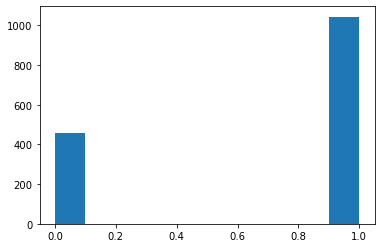

In [387]:
plt.hist(pca_100_train_2_s)
plt.show()

In [364]:
kmeans_20 = KMeans(n_clusters=20,n_jobs=-1, random_state=22)
kmeans_20 = kmeans_20.fit(x_train)
pca_500_train_20_s = kmeans_20.predict(x_train)
pca_500_test_20_s = kmeans_20.predict(x_test)

E:\ANACONDA\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


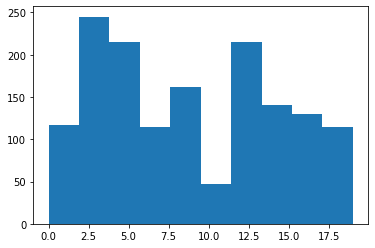

In [365]:
plt.hist(pca_500_train_20_s)
plt.show()

In [397]:
#train_feature["PCA_100_cluster_2_with_concat"] = pca_100_train_2_s
test_feature["PCA_100_cluster_2_with_concat"] = pca_100_test_2_s
#train_feature["PCA_100_cluster_20_with_concat"] = pca_100_train_20_s
test_feature["PCA_100_cluster_20_with_concat"] = pca_100_test_20_s

# PCA = 500

In [18]:
pca_500 = PCA(n_components=500, random_state=22)
pca_500.fit(feat_concate)
x_train = pca_500.transform(feat_concate)
x_test = pca_500.transform(feat_test)

print(sum(pca_500.explained_variance_ratio_))

0.8852189651806839


# Cluster K = 2

In [19]:
kmeans_2 = KMeans(n_clusters=2,n_jobs=-1, random_state=22)
kmeans_2 = kmeans_2.fit(x_train)
pca_500_train_2_s = kmeans_2.predict(x_train)
pca_500_test_2_s = kmeans_2.predict(x_test)

E:\ANACONDA\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


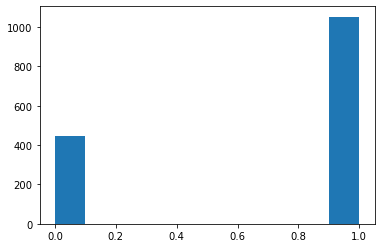

In [392]:
plt.hist(pca_500_train_2_s)
plt.show()

# K = 20

In [393]:
kmeans_20 = KMeans(n_clusters=20,n_jobs=-1, random_state=22)
kmeans_20 = kmeans_20.fit(x_train)
pca_500_train_20_s = kmeans_20.predict(x_train)
pca_500_test_20_s = kmeans_20.predict(x_test)

E:\ANACONDA\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


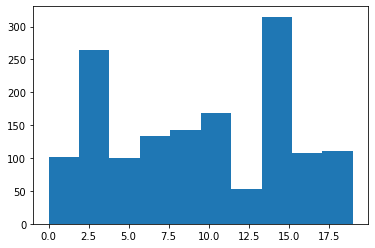

In [394]:
plt.hist(pca_500_train_20_s)
plt.show()

# K = 10

In [20]:
kmeans_10 = KMeans(n_clusters=10,n_jobs=-1, random_state=22)
kmeans_10 = kmeans_10.fit(x_train)
pca_500_train_10_s = kmeans_10.predict(x_train)
pca_500_test_10_s = kmeans_10.predict(x_test)

E:\ANACONDA\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [ ]:
#train_feature["PCA_500_cluster_2_without_concat"] = pca_100_train_2_s
test_feature["PCA_500_cluster_2_with_concat"] = pca_500_test_2_s
#train_feature["PCA_500_cluster_20_without_concat"] = pca_500_train_20_s
test_feature["PCA_500_cluster_20_with_concat"] = pca_500_test_20_s

In [22]:
test_feature["PCA_500_cluster_10_with_concat"] = pca_500_test_10_s

In [23]:
clus_data = pd.DataFrame({"cluster":list(d.keys()),
# "PCA_100_cluster_2_with_concat" : pca_100_train_2_s,
# "PCA_100_cluster_20_with_concat" : pca_500_train_20_s,
# "PCA_500_cluster_2_with_concat" : pca_100_train_2_s,
# "PCA_500_cluster_20_with_concat" : pca_500_train_20_s,
"PCA_500_cluster_10_with_concat" : pca_500_train_10_s,
}
)

In [24]:
train_feature

,id,x,y,color,color_weight,object,object_weight,cluster,PCA_100_cluster_2_without_concat,PCA_100_cluster_20_without_concat,PCA_500_cluster_2_without_concat,PCA_500_cluster_20_without_concat,PCA_100_cluster_2_with_concat,PCA_100_cluster_20_with_concat,PCA_500_cluster_2_with_concat,PCA_500_cluster_20_with_concat,PCA_500_cluster_10_without_concat
0,IMG2744_1,-9.380678,3.58272,[[105.42161563 107.14448812 100.08701536]\n [ ...,"[0.6348333333333334, 0.28917916666666665, 0.07...","['patio', 'lakeside', 'bannister', 'mobile_hom...","[0.5601092, 0.14016706, 0.022413984, 0.0214102...",IMG2744,0,6,0,15,0,0,0,0,9
1,IMG2744_2,-9.380678,3.58272,[[ 70.89338335 69.35952808 46.43450226]\n [2...,"[0.24418333333333334, 0.383675, 0.372141666666...","['lakeside', 'fountain', 'snowplow', 'cab', 'p...","[0.19650029, 0.09605682, 0.07403735, 0.0641981...",IMG2744,0,3,0,0,0,0,0,0,9
2,IMG2744_3,-9.380678,3.58272,[[102.4665223 104.16690078 106.75012681]\n [ ...,"[0.38762083333333336, 0.21436666666666668, 0.3...","['planetarium', 'recreational_vehicle', 'patio...","[0.19081369, 0.18522698, 0.15903644, 0.1425865...",IMG2744,0,3,0,0,0,0,0,0,9
3,IMG2744_4,-9.380678,3.58272,[[172.34591855 173.62166457 174.12597505]\n [ ...,"[0.14006666666666667, 0.80195, 0.0579833333333...","['patio', 'prison', 'vault', 'sliding_door', '...","[0.4598027, 0.09773029, 0.08703377, 0.08668958...",IMG2744,0,10,0,16,0,0,0,0,2
4,IMG2744_5,-9.380678,3.58272,[[176.59672634 180.22641643 181.04637214]\n [ ...,"[0.5870208333333333, 0.24822083333333333, 0.16...","['cliff_dwelling', 'obelisk', 'beacon', 'bell_...","[0.41137695, 0.36667395, 0.047409043, 0.031869...",IMG2744,0,9,0,5,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,IMG4243_1,-4.680678,35.18272,[[128.27104488 134.23647568 138.81402315]\n [1...,"[0.6565333333333333, 0.0879625, 0.255504166666...","['sliding_door', 'bannister', 'cinema', 'dinin...","[0.14514625, 0.14219695, 0.05935542, 0.0578398...",IMG4243,1,8,1,14,1,11,1,11,8
7496,IMG4243_2,-4.680678,35.18272,[[118.48179231 110.87987609 77.6406008 ]\n [1...,"[0.7056708333333334, 0.11548333333333333, 0.17...","['altar', 'tray', 'shield', 'throne', 'chest']","[0.8379609, 0.045215227, 0.021772249, 0.013163...",IMG4243,1,18,1,4,1,11,1,11,1
7497,IMG4243_3,-4.680678,35.18272,[[226.50473934 221.93992891 217.16848341]\n [1...,"[0.5093708333333333, 0.4554625, 0.035166666666...","['church', 'cinema', 'altar', 'monastery', 'th...","[0.22607179, 0.18696362, 0.12684114, 0.1066632...",IMG4243,1,19,1,7,1,11,1,11,7
7498,IMG4243_4,-4.680678,35.18272,[[133.48818234 141.77044155 145.40597314]\n [ ...,"[0.20084166666666667, 0.21566666666666667, 0.5...","['home_theater', 'shoji', 'wardrobe', 'bannist...","[0.19004883, 0.16281106, 0.07418765, 0.0505939...",IMG4243,1,13,1,9,1,11,1,11,3


In [26]:
merged = train_feature.merge(clus_data, left_on='cluster', right_on='cluster')

In [404]:
merged.head(5)

,id,x,y,color,color_weight,object,object_weight,cluster,PCA_100_cluster_2_without_concat,PCA_100_cluster_20_without_concat,PCA_500_cluster_2_without_concat,PCA_500_cluster_20_without_concat,PCA_100_cluster_2_with_concat,PCA_100_cluster_20_with_concat,PCA_500_cluster_2_with_concat,PCA_500_cluster_20_with_concat
0,IMG2744_1,-9.380678,3.58272,[[105.42161563 107.14448812 100.08701536]\n [ ...,"[0.6348333333333334, 0.28917916666666665, 0.07...","['patio', 'lakeside', 'bannister', 'mobile_hom...","[0.5601092, 0.14016706, 0.022413984, 0.0214102...",IMG2744,0,6,0,15,0,0,0,0
1,IMG2744_2,-9.380678,3.58272,[[ 70.89338335 69.35952808 46.43450226]\n [2...,"[0.24418333333333334, 0.383675, 0.372141666666...","['lakeside', 'fountain', 'snowplow', 'cab', 'p...","[0.19650029, 0.09605682, 0.07403735, 0.0641981...",IMG2744,0,3,0,0,0,0,0,0
2,IMG2744_3,-9.380678,3.58272,[[102.4665223 104.16690078 106.75012681]\n [ ...,"[0.38762083333333336, 0.21436666666666668, 0.3...","['planetarium', 'recreational_vehicle', 'patio...","[0.19081369, 0.18522698, 0.15903644, 0.1425865...",IMG2744,0,3,0,0,0,0,0,0
3,IMG2744_4,-9.380678,3.58272,[[172.34591855 173.62166457 174.12597505]\n [ ...,"[0.14006666666666667, 0.80195, 0.0579833333333...","['patio', 'prison', 'vault', 'sliding_door', '...","[0.4598027, 0.09773029, 0.08703377, 0.08668958...",IMG2744,0,10,0,16,0,0,0,0
4,IMG2744_5,-9.380678,3.58272,[[176.59672634 180.22641643 181.04637214]\n [ ...,"[0.5870208333333333, 0.24822083333333333, 0.16...","['cliff_dwelling', 'obelisk', 'beacon', 'bell_...","[0.41137695, 0.36667395, 0.047409043, 0.031869...",IMG2744,0,9,0,5,0,0,0,0


In [406]:
test_feature.head()

,id,color,weight,object,object_weight,PCA_100_cluster_2_without_concat,PCA_100_cluster_20_without_concat,PCA_500_cluster_2_without_concat,PCA_500_cluster_20_without_concat,PCA_500_cluster_2_with_concat,PCA_500_cluster_20_with_concat,PCA_100_cluster_2_with_concat,PCA_100_cluster_20_with_concat
0,IMG4287_3,[[ 73.6183987 65.63426149 48.97455157]\n [1...,"[0.4972, 0.23238333333333333, 0.2704166666666667]","['sliding_door', 'bookcase', 'medicine_chest',...","[0.22203007, 0.07611684, 0.07113481, 0.0683116...",1,13,1,9,1,14,1,13
1,IMG4288_5,[[137.14717413 138.33202102 138.31306933]\n [2...,"[0.5061833333333333, 0.17682083333333334, 0.31...","['window_shade', 'bannister', 'binoculars', 's...","[0.2997648, 0.24434192, 0.10294387, 0.09043626...",0,7,0,3,1,18,1,7
2,IMG4289_5,[[175.80050757 183.23411583 156.67026194]\n [1...,"[0.33195416666666666, 0.6221166666666667, 0.04...","['wardrobe', 'chiffonier', 'vestment', 'throne...","[0.95141023, 0.016296614, 0.008123173, 0.00781...",1,4,1,7,1,4,1,4
3,IMG4290_4,[[ 77.09971878 81.18058383 43.14020676]\n [2...,"[0.07971666666666667, 0.3940458333333333, 0.52...","['lakeside', 'breakwater', 'mobile_home', 'rec...","[0.16709629, 0.08717257, 0.059366558, 0.043662...",0,6,0,15,0,3,0,6
4,IMG4291_5,[[119.37971298 122.01727819 122.79116501]\n [1...,"[0.5002416666666667, 0.3787375, 0.121020833333...","['missile', 'bannister', 'projectile', 'patio'...","[0.5303798, 0.13834873, 0.109011896, 0.0902504...",0,11,0,16,0,15,0,11


In [27]:
merged.to_csv("data/train_features.csv",index = False)
test_feature.to_csv("data/test_features.csv",index = False)